In [1]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


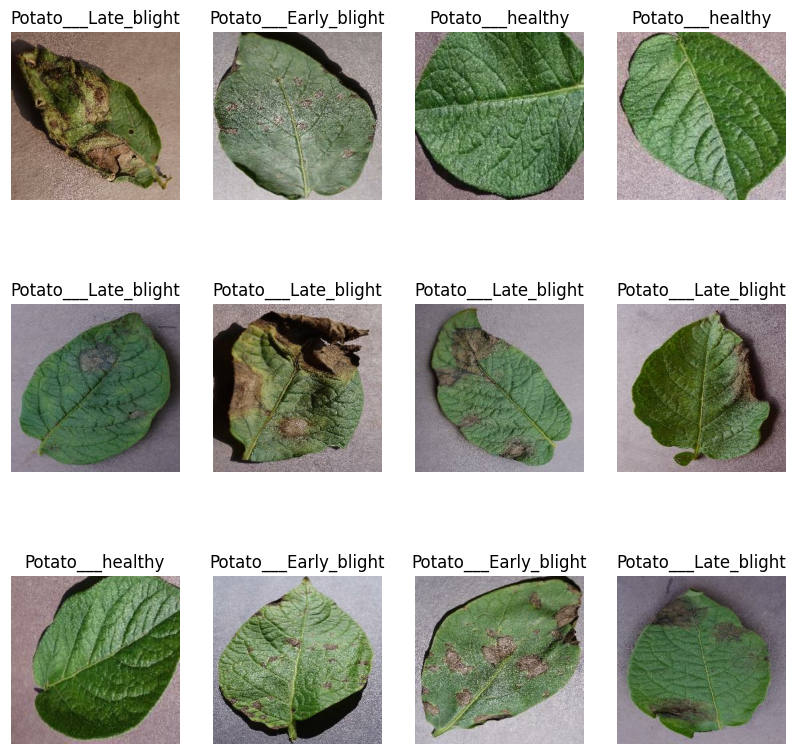

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

94

In [8]:
train_size = 0.8
len(dataset)*train_size

75.2

In [9]:
train_ds = dataset.take(75)
len(train_ds)

75

In [10]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [11]:
val_size=0.1
len(dataset)*val_size

9.4

In [12]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [13]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  75
Validation Dataset Size:  9
Test Dataset Size:  10


In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
75/75 [==============================] - 118s 993ms/step - loss: 1.1037 - accuracy: 0.3946 - val_loss: 0.7785 - val_accuracy: 0.7708
Epoch 2/50
75/75 [==============================] - 37s 498ms/step - loss: 0.9002 - accuracy: 0.5865 - val_loss: 0.5919 - val_accuracy: 0.7396
Epoch 3/50
75/75 [==============================] - 42s 566ms/step - loss: 0.6473 - accuracy: 0.7191 - val_loss: 0.5509 - val_accuracy: 0.7465
Epoch 4/50
75/75 [==============================] - 43s 572ms/step - loss: 0.5021 - accuracy: 0.7968 - val_loss: 0.2140 - val_accuracy: 0.9340
Epoch 5/50
75/75 [==============================] - 41s 547ms/step - loss: 0.3932 - accuracy: 0.8591 - val_loss: 0.2861 - val_accuracy: 0.8924
Epoch 6/50
75/75 [==============================] - 44s 586ms/step - loss: 0.3368 - accuracy: 0.8708 - val_loss: 0.1928 - val_accuracy: 0.9236
Epoch 7/50
75/75 [==============================] - 50s 664ms/step - loss: 0.3250 - accuracy: 0.8867 - val_loss: 0.0900 - val_accuracy: 0.968

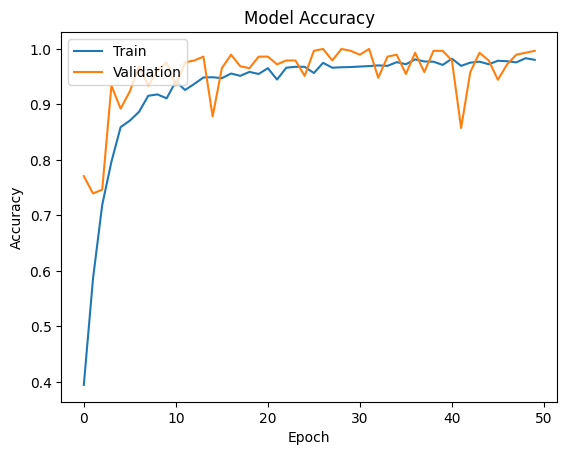

In [24]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

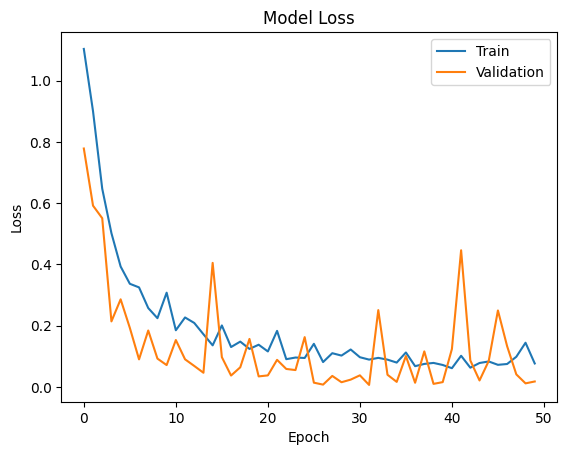

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

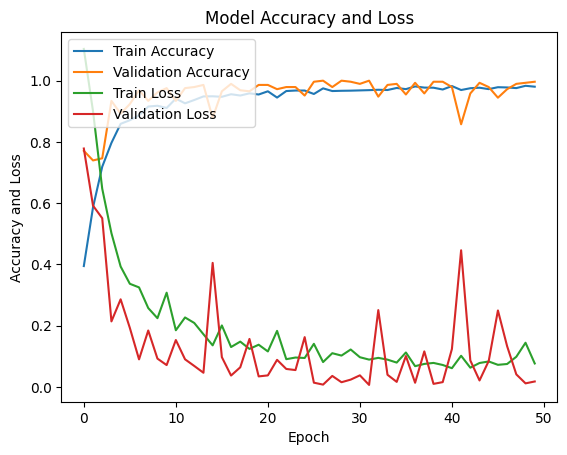

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [27]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

10/10 [==============================] - 14s 64ms/step - loss: 0.0353 - accuracy: 0.9875


[0.39464882016181946,
 0.5865384340286255,
 0.7190635204315186,
 0.796822726726532,
 0.8591136932373047,
 0.8708193898200989,
 0.8867056965827942,
 0.9155518412590027,
 0.9180601835250854,
 0.910953164100647,
 0.9414715766906738,
 0.9260033369064331,
 0.9368728995323181,
 0.9485785961151123,
 0.9489966630935669,
 0.9473243951797485,
 0.9556856155395508,
 0.9515050053596497,
 0.9586120247840881,
 0.9548494815826416,
 0.965300977230072,
 0.9448160529136658,
 0.9661371111869812,
 0.9678093791007996,
 0.9678093791007996,
 0.95652174949646,
 0.974916398525238,
 0.9661371111869812,
 0.9669732451438904,
 0.967391312122345,
 0.9682274460792542,
 0.9690635204315186,
 0.9703177213668823,
 0.9694815874099731,
 0.976170539855957,
 0.9724080562591553,
 0.9811872839927673,
 0.9774247407913208,
 0.9770066738128662,
 0.9711538553237915,
 0.9824414849281311,
 0.9694815874099731,
 0.9753344655036926,
 0.9770066738128662,
 0.9724080562591553,
 0.9786789417266846,
 0.9778428077697754,
 0.9757525324821472,

In [28]:
history.history['val_accuracy']

[0.7708333134651184,
 0.7395833134651184,
 0.7465277910232544,
 0.9340277910232544,
 0.8923611044883728,
 0.9236111044883728,
 0.96875,
 0.9340277910232544,
 0.9618055820465088,
 0.9756944179534912,
 0.9340277910232544,
 0.9756944179534912,
 0.9791666865348816,
 0.9861111044883728,
 0.8784722089767456,
 0.9652777910232544,
 0.9895833134651184,
 0.96875,
 0.9652777910232544,
 0.9861111044883728,
 0.9861111044883728,
 0.9722222089767456,
 0.9791666865348816,
 0.9791666865348816,
 0.9513888955116272,
 0.9965277910232544,
 1.0,
 0.9791666865348816,
 1.0,
 0.9965277910232544,
 0.9895833134651184,
 1.0,
 0.9479166865348816,
 0.9861111044883728,
 0.9895833134651184,
 0.9548611044883728,
 0.9930555820465088,
 0.9583333134651184,
 0.9965277910232544,
 0.9965277910232544,
 0.9791666865348816,
 0.8576388955116272,
 0.9583333134651184,
 0.9930555820465088,
 0.9791666865348816,
 0.9444444179534912,
 0.9722222089767456,
 0.9895833134651184,
 0.9930555820465088,
 0.9965277910232544]

In [29]:
history.history['loss']

[1.103670358657837,
 0.9002223014831543,
 0.6472644805908203,
 0.5020777583122253,
 0.3931715190410614,
 0.336810827255249,
 0.32501545548439026,
 0.2575441300868988,
 0.224511057138443,
 0.3077363073825836,
 0.18505793809890747,
 0.226854607462883,
 0.20891155302524567,
 0.17196883261203766,
 0.13576273620128632,
 0.20079365372657776,
 0.13029231131076813,
 0.14798802137374878,
 0.12412809580564499,
 0.1378134787082672,
 0.11586466431617737,
 0.1830444484949112,
 0.09060291200876236,
 0.09601608663797379,
 0.09452547878026962,
 0.1407979428768158,
 0.08122896403074265,
 0.11015243083238602,
 0.10234048962593079,
 0.12223012000322342,
 0.09699276089668274,
 0.08922670036554337,
 0.09490075707435608,
 0.08913558721542358,
 0.07950026541948318,
 0.11249155551195145,
 0.0678219273686409,
 0.0751398429274559,
 0.0784071683883667,
 0.07170319557189941,
 0.061183054000139236,
 0.10178257524967194,
 0.06284475326538086,
 0.07814179360866547,
 0.08316934108734131,
 0.07219074666500092,
 0.0748

In [30]:
history.history['val_loss']

[0.7784813046455383,
 0.5918875336647034,
 0.550889253616333,
 0.21397317945957184,
 0.2860734462738037,
 0.19283999502658844,
 0.09003035724163055,
 0.1842392086982727,
 0.09251341223716736,
 0.07131411135196686,
 0.15317289531230927,
 0.09016542136669159,
 0.06852445006370544,
 0.046309489756822586,
 0.40507179498672485,
 0.0973115861415863,
 0.03718395158648491,
 0.06409803032875061,
 0.15673820674419403,
 0.034404024481773376,
 0.03765299543738365,
 0.08847382664680481,
 0.05871884152293205,
 0.05506733059883118,
 0.16262857615947723,
 0.013896211981773376,
 0.0075799282640218735,
 0.03594636917114258,
 0.015337239019572735,
 0.023879801854491234,
 0.03786194324493408,
 0.006568104960024357,
 0.2508460283279419,
 0.0397038534283638,
 0.01653323695063591,
 0.10088767111301422,
 0.013662281446158886,
 0.11604634672403336,
 0.010003975592553616,
 0.015717417001724243,
 0.12382537871599197,
 0.4462343752384186,
 0.08659221976995468,
 0.021116454154253006,
 0.08487200736999512,
 0.24968

In [31]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.987500011920929
Loss:  0.03526262938976288


In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

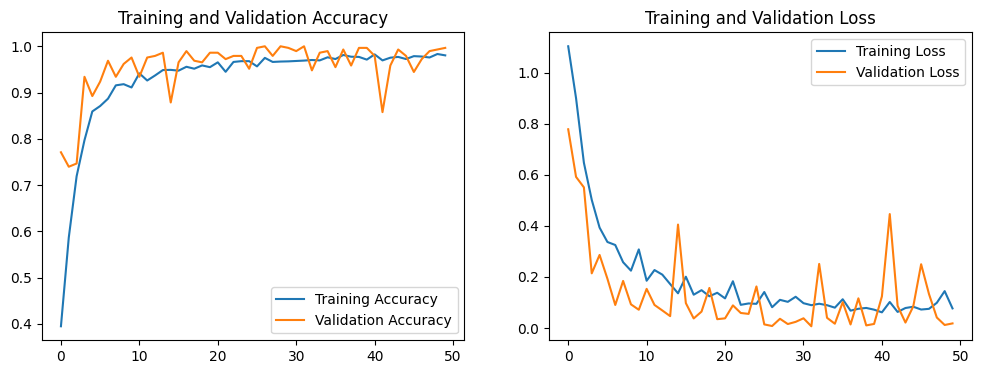

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
[1.1033232e-09 9.9999988e-01 9.3854105e-08]
Max Value: 1
Predicted Label: Potato___Late_blight


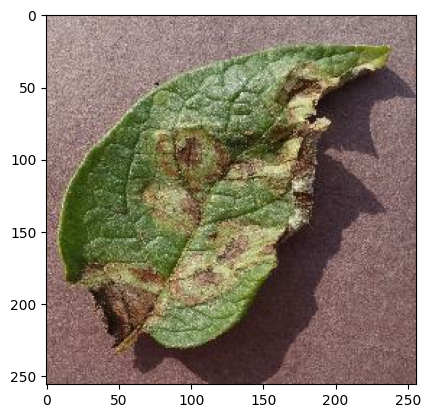

In [34]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


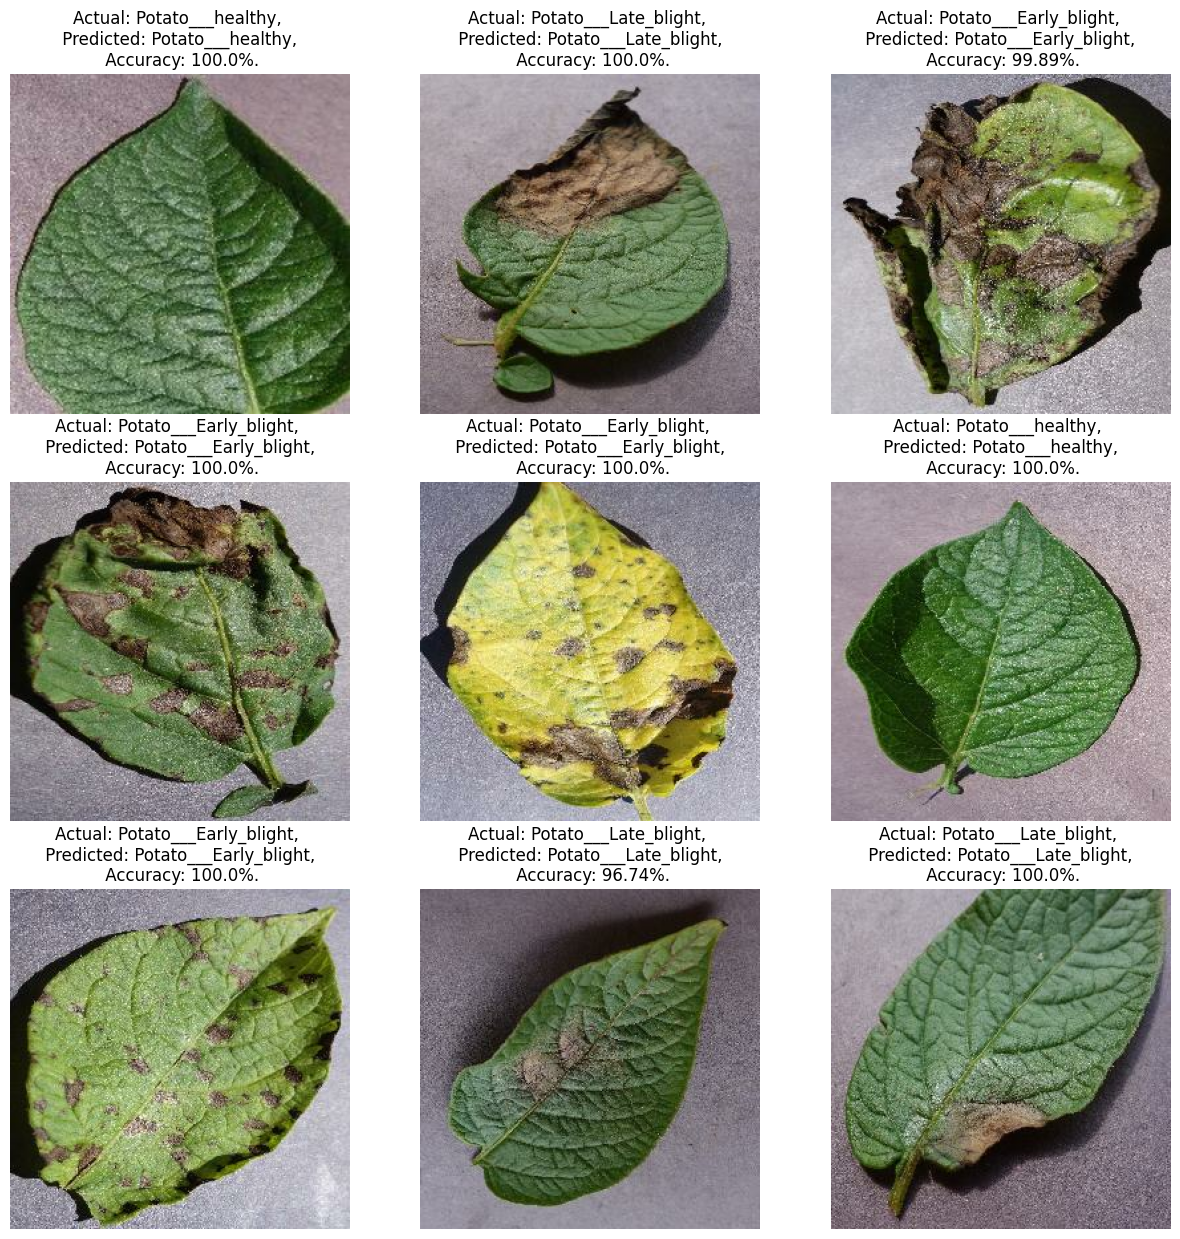

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [37]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  98.7500011920929


In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

10/10 [==============================] - 1s 51ms/step
F1 Score:  42.82658112833051
Precision Score:  42.85673253676471
Recall Score:  42.8125


10/10 [==============================] - 1s 57ms/step


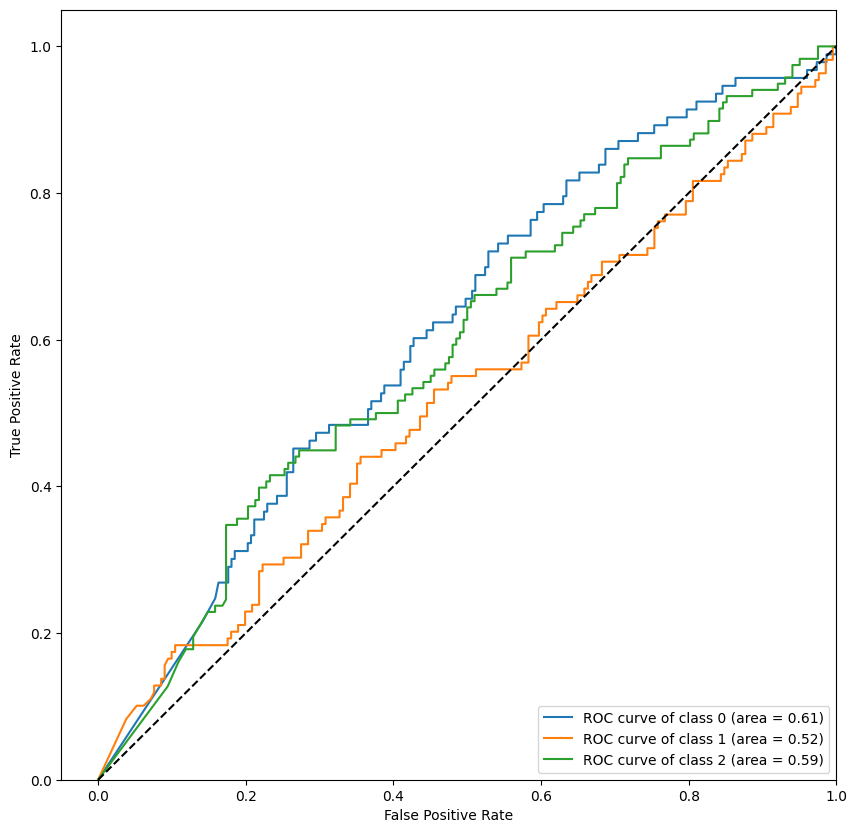

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

10/10 [==============================] - 0s 51ms/step


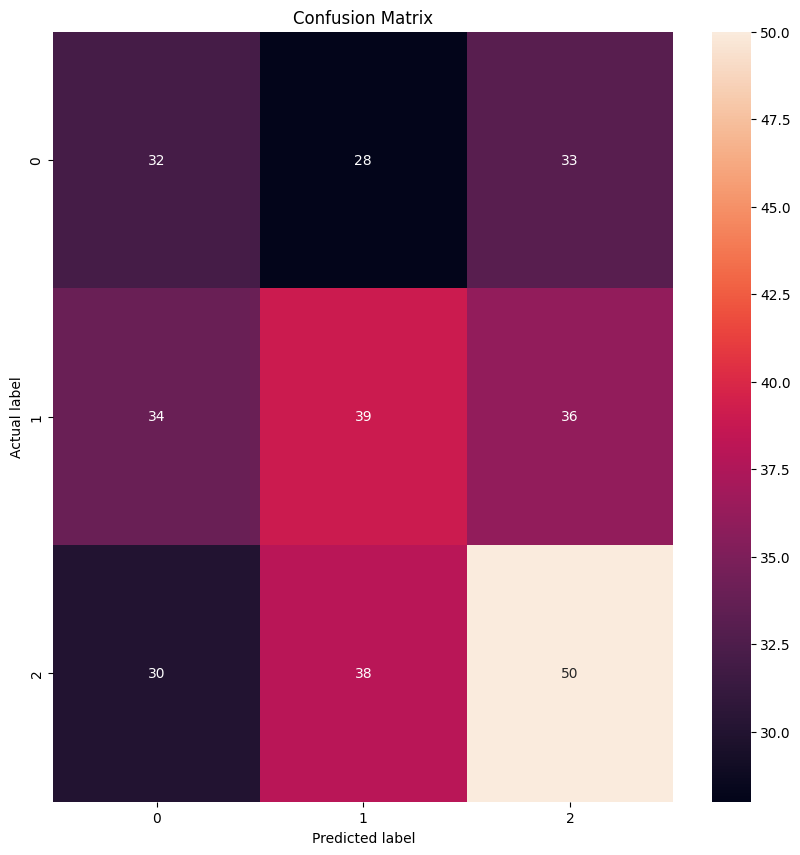

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()